Meeting 05/08/2025 @ SISSA:
Visualization of the degree distribution of graphs **with the clique** (`p_reduce` correction).

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from scipy.stats import binom

sys.path.append(os.path.abspath(os.path.join('..', '..')))

import src.graphs_generation as graphs_generation

# Graphs with clique

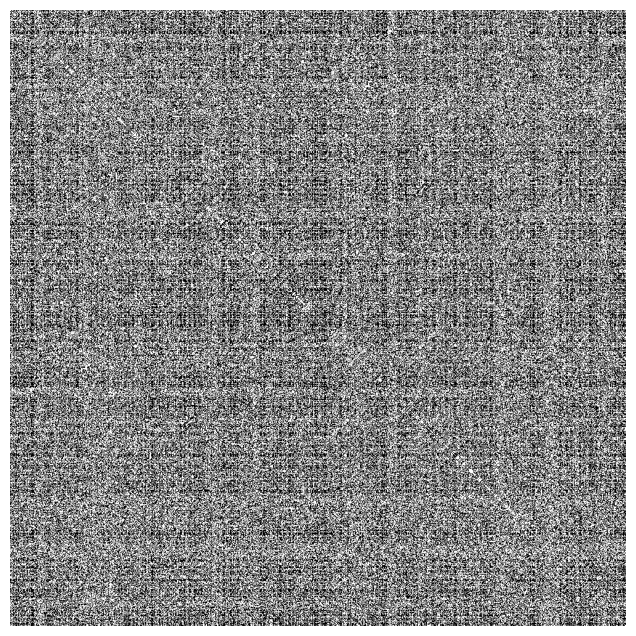

In [68]:
# visualizing input for graph of 160 nodes and clique of 70, "p_increase"
graph_with_clique = graphs_generation.generate_batch(1, 1000, [300], "p_reduce", False, p_clique=1)
# visualizing single image without axes:
plt.figure(figsize=(8, 8))
plt.axis('off')  # Remove the axes
plt.imshow(np.squeeze(graph_with_clique[0]), cmap='gray_r')
plt.show()

Each row in the matrix above represents the connections of a certain node with all the other nodes in the graph. Each node can either be part of the clique or not. The degree distribution of the entire graph can therefore be described as a mixture of two distinct distributions, corresponding to two cases:

1. *Nodes inside the clique* ("in-group"): deterministically connected to all other (k - 1) clique members. The remaining (n-k) possible connections to nodes outside the clique are present with probability $p_{corr}$. Therefore the degree ($K$) of a node that is part of the clique is the sum of:
    - ( k-1 ) connections within the clique (no self-connections);
    - a binomial random variable coutning the number of edges to nodes that are not part of the clique

    The probability that a node within the clique has degree $K$ is: $$ p_{ingroup}(K) = \mathrm{BinomialPMF}(K - (k-1); n-k; p_{corr}) $$


2. *Nodes outside the clique* ("out-group"): has (n - 1) possible connections, all random and independently present with probability $p_{corr}$. Thee corresponding probability that a non-clique node has degree $K$ is $$ p_{outgroup}(K) = \mathrm{BinomialPMF}(K; n-1; p_{corr}) $$

Where:
- $K$ is the degree of the graph;
- $n$ is the size of the graph;
- $k$ is the size of the planted clique;
- $p$ is the original probability of association (0.5 by default);
- $p_{corr}$ is the corrected probability of association, calculated as: $p_{corr}=\frac{p \cdot n (n-1) - k (k-1)}{(n - k)(n + k - 1)}$


-----------------------

The complete degree distribution of a graph with the clique is given by a mixture of "p_ingroup" and "p_outgroup":
$$
p(K) = \pi_{ingroup} * p_{ingroup} + (1-\pi_{ingroup}) * p_{outgroup} = \frac{k}{n} * p_{ingroup} + \frac{1-k}{n} * p_{outgroup}
$$

In [69]:
def p_correction(p_nodes, graph_size, clique_size):
    '''Returns the value of the corrected p-value in the graph with clique ("p_reduce" case) '''
    p_corrected = (
        p_nodes * graph_size * (graph_size - 1)
        - clique_size * (clique_size - 1)
    ) / ((graph_size - clique_size) * (graph_size + clique_size - 1))
    return p_corrected

def p_ingroup(degree, graph_size, clique_size):
    ''' For a given degree value, returns the probability that a node INSIDE the clique has exactly that degree '''
    return binom.pmf(degree - (clique_size-1),      # number of non-clique connections
                     graph_size - clique_size,  # number of possible non-clique nodes
                     p_correction(0.5, graph_size, clique_size)
                     )

def p_outgroup(degree, graph_size, clique_size):
    ''' For a given degree value, returns the probability that a node OUTSIDE the clique has exactly that degree '''
    return binom.pmf(degree, 
                     graph_size-1, 
                     p_correction(0.5, graph_size, clique_size)
                     )

def degree_distribution_clique(degree, graph_size, clique_size):
    '''Combines p_outgroup and p_ingroup (single mixture) to obtain the overall degree distribution of the graph with the clique'''
    return clique_size/graph_size * p_ingroup(degree, graph_size, clique_size) + (1-clique_size/graph_size) * p_outgroup(degree, graph_size, clique_size)

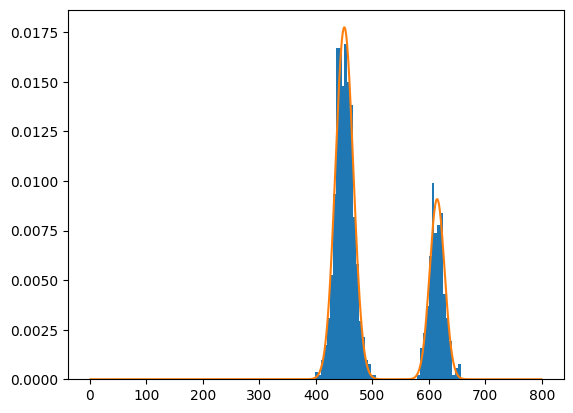

In [70]:
# plotting "empirical" degree distribution of the graph:
plt.hist(np.sum(np.array(np.squeeze(graph_with_clique[0])), axis=1), bins=50, density=True)
# plotting the "expected" degree distribution of the graph:
degree_range = np.arange(1, 800, dtype="int")
plt.plot(degree_range, degree_distribution_clique(degree_range, graph_size=1000, clique_size=300))

# Graphs without clique

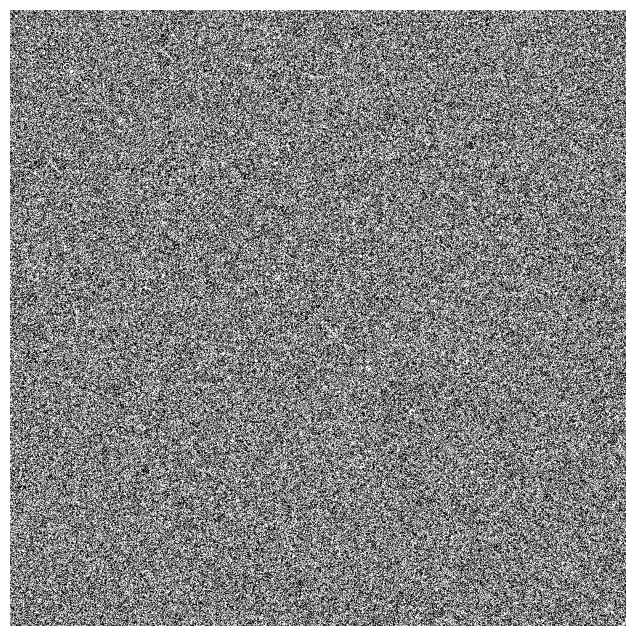

In [71]:
# visualizing input for graph of 160 nodes and clique of 70, "p_increase"
graph_without_clique = graphs_generation.generate_batch(1, 1000, [300], "p_reduce", False, p_clique=0.00001)
# visualizing single image without axes:
plt.figure(figsize=(8, 8))
plt.axis('off')  # Remove the axes
plt.imshow(np.squeeze(graph_without_clique[0]), cmap='gray_r')
plt.show()

In [72]:
def p_noclique(degree, graph_size):
    ''' For a given degree value, returns the probability that a node of a graph without the clique has exactly that degree '''
    return binom.pmf(degree, 
                     graph_size-1, 
                     0.5    # "p_reduce" correction only acts on graph with clique
                     )

def degree_distribution_noclique(degree, graph_size):
    '''Combines p_outgroup and p_ingroup (single mixture) to obtain the overall degree distribution of the graph with the clique'''
    return p_noclique(degree, graph_size)

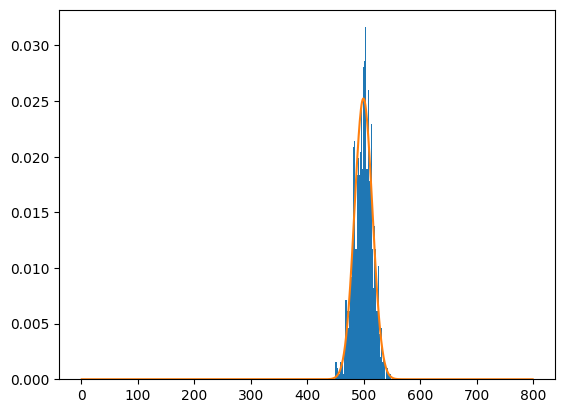

In [73]:
# plotting "empirical" degree distribution of the graph:
plt.hist(np.sum(np.array(np.squeeze(graph_without_clique[0])), axis=1), bins=50, density=True)
# plotting the "expected" degree distribution of the graph:
degree_range = np.arange(1, 800, dtype="int")
plt.plot(degree_range, degree_distribution_noclique(degree_range, graph_size=1000))

# Unique plot:

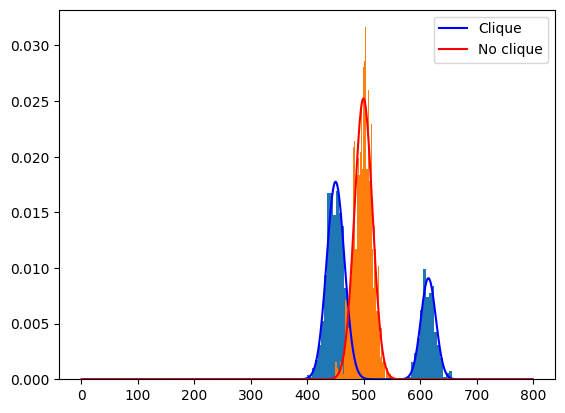

In [74]:
# CLIQUE
plt.hist(np.sum(np.array(np.squeeze(graph_with_clique[0])), axis=1), bins=50, density=True)
plt.plot(degree_range, degree_distribution_clique(degree_range, graph_size=1000, clique_size=300), 'blue', label="Clique")

# NOCLIQUE
plt.hist(np.sum(np.array(np.squeeze(graph_without_clique[0])), axis=1), bins=50, density=True)
plt.plot(degree_range, degree_distribution_noclique(degree_range, graph_size=1000), 'red', label="No clique")

plt.legend()